In [4]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import cv2
import sklearn
import PIL
import torch
import torchvision
from matplotlib import cm

import warnings
warnings.filterwarnings('ignore')

### Зачем
- Посмотрим, как проводится операция свертки;
- Посмотрим, как работает pooling;
- Попробуем собрать сверточную нейронную сеть на PyTorch

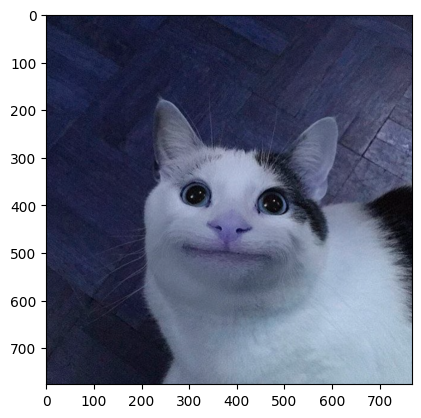

In [5]:
image = cv2.imread('./image.png')
plt.imshow(image);

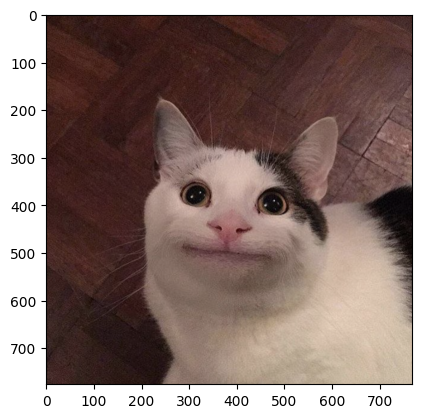

In [6]:
image_ex = image[...,::-1]
plt.imshow(image_ex)

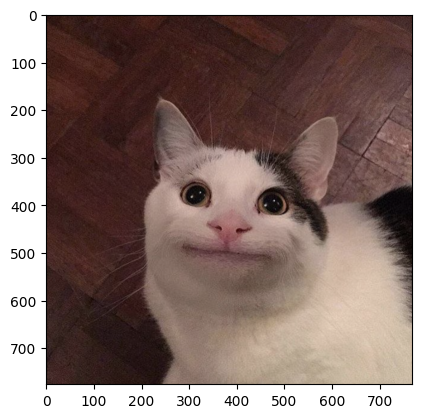

In [7]:
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
plt.imshow(image_rgb);

Посмотрим на каналы изображения отдельно

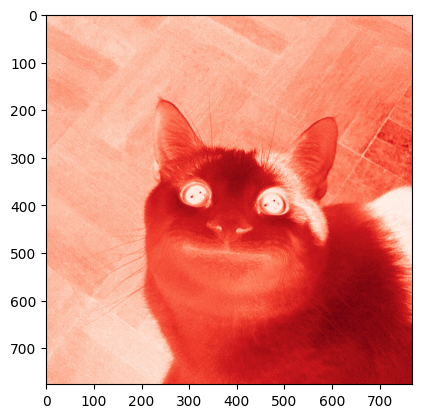

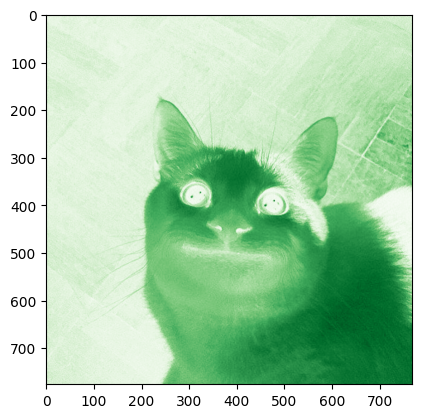

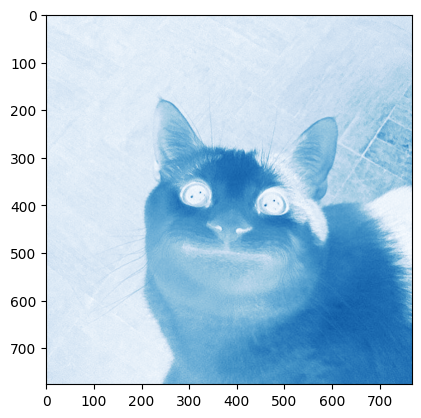

In [8]:
img_mat = np.array(image_rgb)
plt.imshow(img_mat[:, :, 0], cmap=cm.Reds)
plt.show()

img_mat = np.array(image_rgb)
plt.imshow(img_mat[:, :, 1], cmap=cm.Greens)
plt.show()

img_mat = np.array(image_rgb)
plt.imshow(img_mat[:, :, 2], cmap=cm.Blues)
plt.show()

# Операция свертки

- Количество входных каналов `in_channels`
- Количество выходных каналов `out_channels`
- Размер ядра `kernel_size`
- Шаг `stride`
- Паддинг `padding`
- Режим паддинга `padding_mode` (`'zeros'`, `'reflect'`, ...)


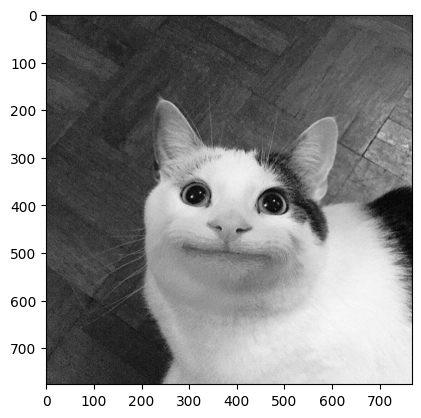

In [9]:
bw_image = cv2.imread('./image.png', cv2.IMREAD_GRAYSCALE)
plt.imshow(bw_image, cmap=plt.cm.Greys_r)

In [ ]:
# !pip3 install scipy

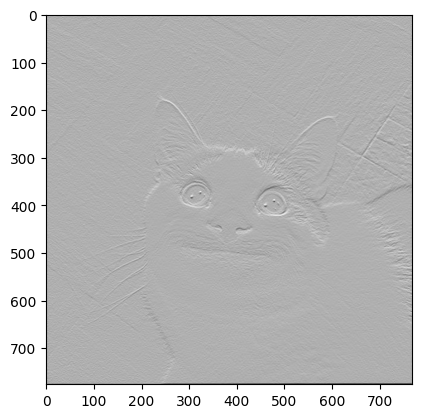

In [12]:
from scipy.signal import convolve2d

G_y = np.array([
    [1, 2, 1],
    [0, 0, 0],
    [-1, -2, -1]
])

res_y = convolve2d(bw_image, G_y, "same")
plt.imshow(res_y, cmap=plt.cm.Greys_r)

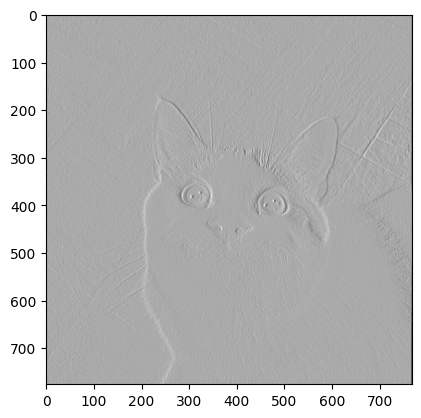

In [13]:
G_x = np.array([
    [-1, 0, 1],
    [-2, 0, 2],
    [-1, 0, 1]
])

res_x = convolve2d(bw_image, G_y.T, "same")
plt.imshow(res_x, cmap=plt.cm.Greys_r)

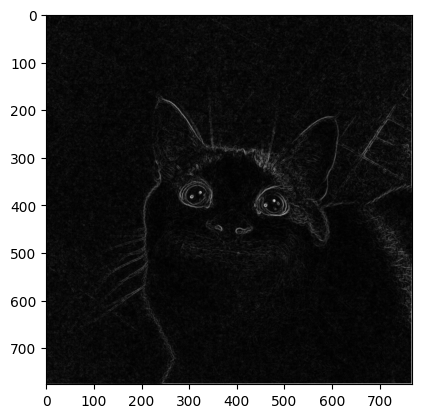

In [14]:
res_sobel = (res_x**2 + res_y**2)**0.5
plt.imshow(res_sobel, cmap=plt.cm.Greys_r)

# Пулинг

In [15]:
import numpy as np

conv_output = np.array([
    [10, 12,  8,  7],
    [ 4, 11,  5,  9],
    [18, 13,  7,  7],
    [ 3, 15,  2,  2]
])
conv_output

array([[10, 12,  8,  7],
       [ 4, 11,  5,  9],
       [18, 13,  7,  7],
       [ 3, 15,  2,  2]])

Сначала попробуем со `stride=2`

In [16]:
pool_size = 2
stride = 2

def get_pools(img=conv_output, pool_size=2, stride=2):

    pools = []
    for i in np.arange(conv_output.shape[0], step=stride):
        for j in np.arange(conv_output.shape[0], step=stride):
            mat = conv_output[i:i+pool_size, j:j+pool_size]
            pools.append(mat)
    pools = np.array(pools)
    return pools

pools = get_pools()
pools

array([[[10, 12],
        [ 4, 11]],

       [[ 8,  7],
        [ 5,  9]],

       [[18, 13],
        [ 3, 15]],

       [[ 7,  7],
        [ 2,  2]]])

In [17]:
def max_pooling(pools: np.array) -> np.array:

    num_pools = pools.shape[0]

    # Размер матрицы после пулинга
    tgt_shape = (int(np.sqrt(num_pools)), int(np.sqrt(num_pools)))

    # Здесь будем хранить максимумы с каждого из пулов
    pooled = []
    for pool in pools:
        pooled.append(np.max(pool))

    return np.array(pooled).reshape(tgt_shape)

In [18]:
max_pooling(pools=pools)

array([[12,  9],
       [18,  7]])

# Сверточная нейронная сеть

In [20]:
import torch
import torch.nn.functional as F
import torchvision
import os
from torch import nn
from tqdm import tqdm

In [21]:
transform = torchvision.transforms.Compose(
    [
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize((0.1307,), (0.3081,))
    ]
)

In [22]:
def seed_everything(seed):
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False


In [23]:
seed_everything(42)

mnist_train = torchvision.datasets.MNIST(
    './mnist/',
    train=True,
    download=True,
    transform=transform
)

mnist_val = torchvision.datasets.MNIST(
    './mnist/',
    train=False,
    download=True,
    transform=transform
)

train_dataloader = torch.utils.data.DataLoader(mnist_train, batch_size=64, shuffle=True)
val_dataloader = torch.utils.data.DataLoader(mnist_val, batch_size=64, shuffle=True)

100.0%
100.0%
100.0%
100.0%


0

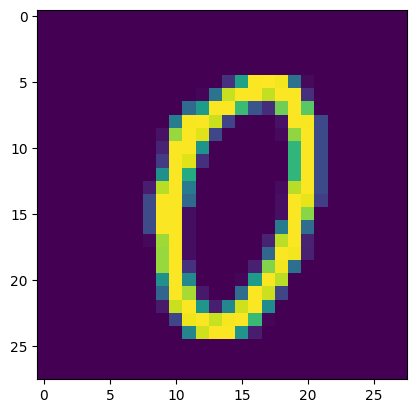

In [58]:
plt.imshow(mnist_train[1000][0].squeeze(0).numpy().reshape([28, 28]))
mnist_train[1000][1]

In [ ]:
model = nn.Sequential(
    nn.Flatten(),
    nn.Linear(28*28, 128),
    nn.ReLU(),
    nn.Linear(128, 10)
)

optimizer = torch.optim.SGD(model.parameters(), lr=0.01)

In [61]:
def train(model, optimizer, n_epochs=5):
    for epoch in range(n_epochs):

        # обучение
        for x_train, y_train in tqdm(train_dataloader):
            y_pred = model(x_train)
            loss = F.cross_entropy(y_pred, y_train)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

        # валидация
        if epoch % 2 == 0:
            val_loss = []
            val_accuracy = []
            with torch.no_grad():
                for x_val, y_val in tqdm(val_dataloader):
                    y_pred = model(x_val)
                    loss = F.cross_entropy(y_pred, y_val)
                    val_loss.append(loss.numpy())
                    val_accuracy.extend((torch.argmax(y_pred, dim=-1) == y_val).numpy().tolist())

            print(f'Epoch: {epoch}, loss: {np.mean(val_loss)}, accuracy: {np.mean(val_accuracy)}')

In [62]:
train(model, optimizer)

100%|██████████| 157/157 [00:00<00:00, 418.85it/s]


Epoch: 0, loss: 0.045016657561063766, accuracy: 0.9855


100%|██████████| 157/157 [00:00<00:00, 419.69it/s]


Epoch: 2, loss: 0.044570889323949814, accuracy: 0.9853


100%|██████████| 157/157 [00:00<00:00, 419.44it/s]

Epoch: 4, loss: 0.03917468711733818, accuracy: 0.9875


In [29]:
0.9462

0.9462

In [30]:
model = nn.Sequential(
    nn.Conv2d(in_channels=1, out_channels=10, kernel_size=5),  # grayscale
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=4),   # сократим изображение в 4 раза по каждой из сторон
    nn.Flatten(),
    nn.Linear(6*6*10, 128),
    nn.ReLU(),
    nn.Linear(128, 10)
)

optimizer = torch.optim.SGD(model.parameters(), lr=0.01)

In [31]:
train(model, optimizer)

100%|██████████| 157/157 [00:00<00:00, 395.53it/s]


Epoch: 0, loss: 0.2660270631313324, accuracy: 0.9249


100%|██████████| 157/157 [00:00<00:00, 403.76it/s]


Epoch: 2, loss: 0.1269400268793106, accuracy: 0.9624


100%|██████████| 157/157 [00:00<00:00, 383.35it/s]

Epoch: 4, loss: 0.0857815071940422, accuracy: 0.9747


In [27]:
0.9747

0.9747

# Домашнее задание

Обучите сверточную нейронную сеть на датасете MNIST, взяв любой другой оптимизатор (кроме SGD) и любую другую функцию ошибки (кроме cross-entropy loss). Попробуйте поварьировать параметры: кол-во ядер, `kernel_size` и побить текущий бейзлайн в `0.9747`. Выведите количество обучаемых параметров.    
Какого качества удалось достичь? Попробуйте залоггировать Ваши результаты - построить графики того, как менялись метрики качества (accuracy, loss) с течением эпох, включить логгирование, сравнить результаты между собой при разных параметрах.

Любые дополнительные улучшения (как по методам, так и по коду пайплайна) приветствуются!

*Цель:* выработать навык обучения нейронных сетей (в частности сверточных) на основе средств PyTorch, начиная от загрузки датасетами и заканчивая выводами результатов, их логгированием, сравнением и анализом.

In [106]:
device = torch.device("mps") if torch.backends.mps.is_available() else torch.device("cpu")
device

device(type='mps')

In [101]:
num_kernels = 128
kernel_size = 3

model = nn.Sequential(
    nn.Conv2d(1, num_kernels, kernel_size=kernel_size),
    nn.ReLU(),
    nn.MaxPool2d(2),
    nn.Flatten(),
    nn.Linear(num_kernels * 13 * 13, 128),
    nn.ReLU(),
    nn.Linear(128, 10)
)

model = model.to(device)

In [102]:
total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
total_params

2771594

In [ ]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
criterion = nn.MSELoss()

def one_hot(labels, num_classes=10):
    return torch.eye(num_classes, device=device)[labels]

In [107]:
def train(model, optimizer, train_dataloader, val_dataloader, n_epochs=5):
    # словарь с четырьмя метриками
    history = {
        "train_loss": [], "train_accuracy": [],
        "val_loss": [], "val_accuracy": []
    }
    # обучение
    for epoch in range(n_epochs):
        model.train()
        train_losses_epoch = []
        train_accuracies_epoch = []
        for x_train, y_train in tqdm(train_dataloader, desc=f"Epoch {epoch+1} Training"):
            x_train, y_train = x_train.to(device), y_train.to(device)
            y_pred = model(x_train)
            loss = F.cross_entropy(y_pred, y_train)
            train_losses_epoch.append(loss.item())
            train_accuracies_epoch.append((torch.argmax(y_pred, dim=-1) == y_train).float().mean().item())
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

        history["train_loss"].append(np.mean(train_losses_epoch))
        history["train_accuracy"].append(np.mean(train_accuracies_epoch))

        # валилация
        model.eval()
        val_losses_epoch = []
        val_accuracies_epoch = []
        with torch.no_grad():
            for x_val, y_val in tqdm(val_dataloader, desc=f"Epoch {epoch+1} Validation"):
                x_val, y_val = x_val.to(device), y_val.to(device)
                y_pred = model(x_val)
                val_losses_epoch.append(F.cross_entropy(y_pred, y_val).item())
                val_accuracies_epoch.append((torch.argmax(y_pred, dim=-1) == y_val).float().mean().item())

        history["val_loss"].append(np.mean(val_losses_epoch))
        history["val_accuracy"].append(np.mean(val_accuracies_epoch))

        print(f"Epoch: {epoch+1}/{n_epochs}, "
              f"Train Loss: {history["train_loss"][-1]}, Train Acc: {history["train_accuracy"][-1]}, "
              f"Val Loss: {history["val_loss"][-1]}, Val Acc: {history["val_accuracy"][-1]}")

    return history

history = train(model, optimizer, train_dataloader, val_dataloader, n_epochs=5)

Epoch 1 Validation: 100%|██████████| 157/157 [00:00<00:00, 201.59it/s]


Epoch: 1/5, Train Loss: 0.031941768518814855, Train Acc: 0.9904384328358209, Val Loss: 0.05090888703700191, Val Acc: 0.9842754777070064


Epoch 2 Validation: 100%|██████████| 157/157 [00:00<00:00, 161.74it/s]


Epoch: 2/5, Train Loss: 0.0267555824948722, Train Acc: 0.992204157782516, Val Loss: 0.050743755471824435, Val Acc: 0.9833797770700637


Epoch 3 Validation: 100%|██████████| 157/157 [00:00<00:00, 200.08it/s]


Epoch: 3/5, Train Loss: 0.023009597874635745, Train Acc: 0.9930870202558635, Val Loss: 0.043514335037143845, Val Acc: 0.9850716560509554


Epoch 4 Validation: 100%|██████████| 157/157 [00:00<00:00, 200.44it/s]


Epoch: 4/5, Train Loss: 0.018572708804481555, Train Acc: 0.9943030383795309, Val Loss: 0.04640088509156511, Val Acc: 0.9851711783439491


Epoch 5 Validation: 100%|██████████| 157/157 [00:00<00:00, 203.76it/s]

Epoch: 5/5, Train Loss: 0.01578477653961786, Train Acc: 0.9955523720682303, Val Loss: 0.05157531151150584, Val Acc: 0.9845740445859873


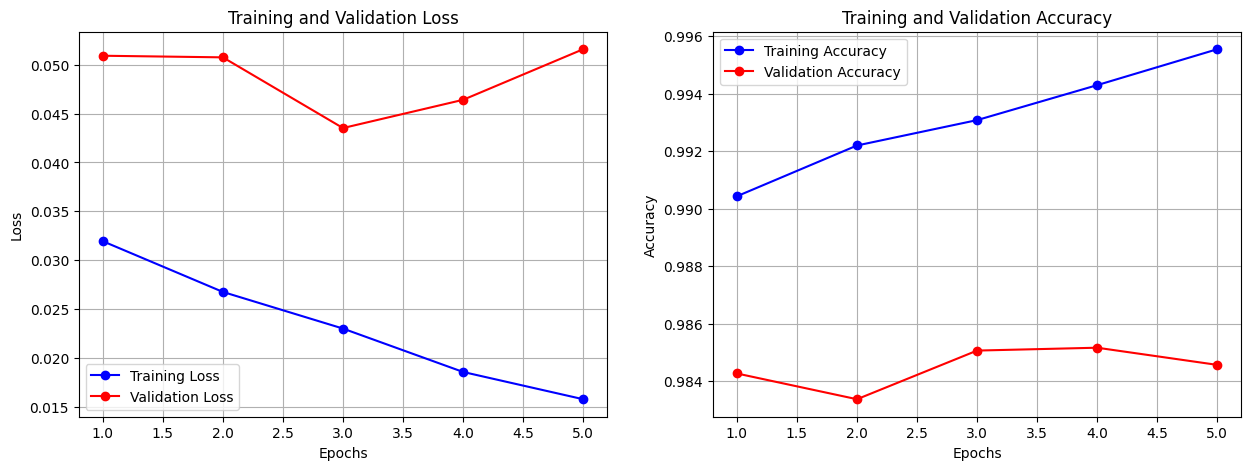

In [109]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

epochs = range(1, len(history['train_loss']) + 1)

ax1.plot(epochs, history['train_loss'], 'bo-', label='Training Loss')
ax1.plot(epochs, history['val_loss'], 'ro-', label='Validation Loss')
ax1.set_title('Training and Validation Loss')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss')
ax1.legend()
ax1.grid(True)

ax2.plot(epochs, history['train_accuracy'], 'bo-', label='Training Accuracy')
ax2.plot(epochs, history['val_accuracy'], 'ro-', label='Validation Accuracy')
ax2.set_title('Training and Validation Accuracy')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Accuracy')
ax2.legend()
ax2.grid(True)

plt.show()

# Вывод
Модель обучилась, но после третьей эпохи начали проявляться признаки переобучения. Начиная с 4й эпохи, метрики на трейне продолжили улучшаться, а на валидации ухудшаться, =>, используем модель, полученную после теретьей эпохи.